In [3]:
# standard python imports
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import copy

# pytorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

In [4]:
data = np.load('exp_io_data\CoupledPendula_mean_in7_out7_Tmax1.0_data.npz')
for key, val in data.items():
    print(key)
    exec(key +'=val')

xlist
exp_out_list


In [5]:
x=xlist
y=exp_out_list
#print(y)

In [6]:
x_in=x[:,0:7]
x_para=x[:,7:14]
print(x_in)
print(x_para)

[[0.24749702 0.02014035 0.8485794  ... 0.08696669 0.99749106 0.38496768]
 [0.75097805 0.60711515 0.67705935 ... 0.44351715 0.26912165 0.6546309 ]
 [0.5515969  0.85570264 0.12367398 ... 0.65876925 0.5144654  0.21687716]
 ...
 [0.42885804 0.77784693 0.23516494 ... 0.04689354 0.62893504 0.55456245]
 [0.20224023 0.34561175 0.6055104  ... 0.47257882 0.73187715 0.20602894]
 [0.8430058  0.8306561  0.3663333  ... 0.44167274 0.54337865 0.5084354 ]]
[[0.88139296 0.7579072  0.70741415 ... 0.20202214 0.9071052  0.7719516 ]
 [0.79979634 0.67036146 0.34607875 ... 0.4598763  0.6044103  0.8825798 ]
 [0.80389327 0.94342834 0.01652193 ... 0.74545115 0.7731646  0.6300963 ]
 ...
 [0.22442555 0.8744122  0.07718152 ... 0.7652486  0.48310757 0.2971735 ]
 [0.77770346 0.10846525 0.17362505 ... 0.7885187  0.4216227  0.8429448 ]
 [0.06028473 0.8461147  0.1516673  ... 0.3736133  0.5765584  0.7606528 ]]


In [7]:
print(x.shape)
print(y.shape)

(2000, 14)
(2, 30, 2000, 7, 2)


In [8]:

y_x=y[0,:,:,:,0]
y_v=y[0,:,:,:,1]/30
print(y_x.shape)
print(y_v.shape)

y_new=np.concatenate((y_x,y_v),axis=2)
y_new=torch.from_numpy(y_new)
y_new=torch.transpose(y_new,0,1)
# print(y_new[1,1:2,:])
# print(y_new[1,2:3,:])
print(y_new.shape)



(30, 2000, 7)
(30, 2000, 7)
torch.Size([2000, 30, 14])


In [9]:
#y1=y[0:1,29:30,:,:,0:1]
print(y.shape)

F=3 #Fth frame
y2=y[0:1,:,0:1000,:,0:1]
y2_np=torch.from_numpy(y2)
y2=torch.transpose(y2_np,1,2)
print(y2.shape)
y3=y2.squeeze(0).squeeze(3)
print(y3.shape)
y_train=y3[:,F:F+1,:]
print(y_train.shape)

(2, 30, 2000, 7, 2)
torch.Size([1, 1000, 30, 7, 1])
torch.Size([1000, 30, 7])
torch.Size([1000, 1, 7])


In [10]:
x_train=x_in[0:1000,:]
x_train2=x[0:1000,:]
print(x_train.shape)
print(x)

(1000, 7)
[[0.24749702 0.02014035 0.8485794  ... 0.20202214 0.9071052  0.7719516 ]
 [0.75097805 0.60711515 0.67705935 ... 0.4598763  0.6044103  0.8825798 ]
 [0.5515969  0.85570264 0.12367398 ... 0.74545115 0.7731646  0.6300963 ]
 ...
 [0.42885804 0.77784693 0.23516494 ... 0.7652486  0.48310757 0.2971735 ]
 [0.20224023 0.34561175 0.6055104  ... 0.7885187  0.4216227  0.8429448 ]
 [0.8430058  0.8306561  0.3663333  ... 0.3736133  0.5765584  0.7606528 ]]


In [11]:



class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        self.layer1 = nn.Linear(14, 14 ,bias=True)
        self.layer2 = nn.Linear(14, 14,bias=True)
        self.layer3 = nn.Linear(14, 14,bias=True)
        self.layer4 = nn.Linear(14, 14,bias=True)
    def forward(self, x,activation="RELU"):
        
        if activation=="RELU":
            x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
            x = x+(self.layer1(x))
            x = x+(self.layer2(x))
            x = x+(self.layer3(x))
            x = self.layer4(x)
        if activation=="SIG":
            x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
            x = x+torch.sigmoid(self.layer1(x))
            x = x+torch.sigmoid(self.layer2(x))
            x = x+torch.sigmoid(self.layer3(x))
            x = self.layer4(x)
        return x
net = Net()
print(net)

Net(
  (layer1): Linear(in_features=14, out_features=14, bias=True)
  (layer2): Linear(in_features=14, out_features=14, bias=True)
  (layer3): Linear(in_features=14, out_features=14, bias=True)
  (layer4): Linear(in_features=14, out_features=14, bias=True)
)


In [12]:
params = list(net.parameters())

print(len(params))
print(params[0].size())

8
torch.Size([14, 14])


In [13]:
x_input=y_new[0:1000,0:1,:].squeeze(1)
print(x_input.shape)
input = x_input
out = net(input)
y_train=y_new[0:1000,3:4,:]

torch.Size([1000, 14])


In [14]:
net.zero_grad()
out.backward(torch.randn(1000,14))


In [15]:
target=y_train
target_new=target.view(1000,14)
print(target_new.shape)
criterion=nn.MSELoss()
loss=criterion(out,target_new)
print(loss)
print(target_new.shape)

torch.Size([1000, 14])
tensor(0.7686, grad_fn=<MseLossBackward>)
torch.Size([1000, 14])


In [16]:
import torch.optim as optim
optimizer = torch.optim.Adam(params, lr=0.01, betas=(0.9, 0.999), eps=1e-09, weight_decay=0.1, amsgrad=False)  #adam optimizer
    
for i in range(100):
    optimizer.zero_grad()   # zero the gradient buffers
    output = net(input)
    loss = criterion(output, target_new)
    loss.backward()
    optimizer.step()
    print(loss)


tensor(0.7686, grad_fn=<MseLossBackward>)
tensor(0.5787, grad_fn=<MseLossBackward>)
tensor(0.4452, grad_fn=<MseLossBackward>)
tensor(0.3511, grad_fn=<MseLossBackward>)
tensor(0.2835, grad_fn=<MseLossBackward>)
tensor(0.2341, grad_fn=<MseLossBackward>)
tensor(0.1974, grad_fn=<MseLossBackward>)
tensor(0.1697, grad_fn=<MseLossBackward>)
tensor(0.1484, grad_fn=<MseLossBackward>)
tensor(0.1319, grad_fn=<MseLossBackward>)
tensor(0.1189, grad_fn=<MseLossBackward>)
tensor(0.1084, grad_fn=<MseLossBackward>)
tensor(0.0999, grad_fn=<MseLossBackward>)
tensor(0.0929, grad_fn=<MseLossBackward>)
tensor(0.0870, grad_fn=<MseLossBackward>)
tensor(0.0820, grad_fn=<MseLossBackward>)
tensor(0.0777, grad_fn=<MseLossBackward>)
tensor(0.0739, grad_fn=<MseLossBackward>)
tensor(0.0705, grad_fn=<MseLossBackward>)
tensor(0.0673, grad_fn=<MseLossBackward>)
tensor(0.0645, grad_fn=<MseLossBackward>)
tensor(0.0618, grad_fn=<MseLossBackward>)
tensor(0.0593, grad_fn=<MseLossBackward>)
tensor(0.0570, grad_fn=<MseLossBac

In [30]:


y_test=y_new[1000:2000,15:15+1,:]
print(y_test.shape)
y_test_new=torch.transpose(y_test,1,2).squeeze(2)

torch.Size([1000, 1, 14])


In [31]:
x_test=y_new[1000:2000,12:13,:].squeeze(1)

test_out=net(x_test)
print(test_out)

tensor([[ 0.5777, -0.7764, -1.0728,  ...,  0.0177,  0.2905,  0.1858],
        [-0.7635, -0.6461, -0.7450,  ..., -0.0894,  0.0311,  0.0605],
        [-0.4117,  0.5343,  0.5327,  ...,  0.1906, -0.2559, -0.1122],
        ...,
        [-0.7518,  0.3289,  0.0696,  ...,  0.1339, -0.2528, -0.0546],
        [-0.1825,  0.3434,  0.0733,  ..., -0.0023, -0.2428,  0.0132],
        [-0.8474, -0.1180, -0.7559,  ..., -0.0027,  0.0120, -0.2893]],
       grad_fn=<AddmmBackward>)


In [25]:
optimizer = torch.optim.Adam(params, lr=0.0001, betas=(0.9, 0.999), eps=1e-09, weight_decay=0.1, amsgrad=False)  #adam optimizer
total_loss=0
for t in range(100):
    for i in range(5):
        x_input=y_new[0:1000,3*i:3*i+1,:].squeeze(1)
        output=net(x_input)
        target_new=y_new[0:1000,3*i+3:4+3*i,:].squeeze(1)
        loss = criterion(output, target_new)
        total_loss+=loss
        loss.backward()
        optimizer.step()
        print(loss)
  

tensor(0.1623, grad_fn=<MseLossBackward>)
tensor(0.1172, grad_fn=<MseLossBackward>)
tensor(0.1516, grad_fn=<MseLossBackward>)
tensor(0.1775, grad_fn=<MseLossBackward>)
tensor(0.1764, grad_fn=<MseLossBackward>)
tensor(0.1624, grad_fn=<MseLossBackward>)
tensor(0.1173, grad_fn=<MseLossBackward>)
tensor(0.1514, grad_fn=<MseLossBackward>)
tensor(0.1777, grad_fn=<MseLossBackward>)
tensor(0.1764, grad_fn=<MseLossBackward>)
tensor(0.1626, grad_fn=<MseLossBackward>)
tensor(0.1174, grad_fn=<MseLossBackward>)
tensor(0.1511, grad_fn=<MseLossBackward>)
tensor(0.1779, grad_fn=<MseLossBackward>)
tensor(0.1763, grad_fn=<MseLossBackward>)
tensor(0.1627, grad_fn=<MseLossBackward>)
tensor(0.1174, grad_fn=<MseLossBackward>)
tensor(0.1509, grad_fn=<MseLossBackward>)
tensor(0.1781, grad_fn=<MseLossBackward>)
tensor(0.1762, grad_fn=<MseLossBackward>)
tensor(0.1627, grad_fn=<MseLossBackward>)
tensor(0.1175, grad_fn=<MseLossBackward>)
tensor(0.1506, grad_fn=<MseLossBackward>)
tensor(0.1781, grad_fn=<MseLossBac

tensor(0.1179, grad_fn=<MseLossBackward>)
tensor(0.1025, grad_fn=<MseLossBackward>)
tensor(0.0900, grad_fn=<MseLossBackward>)
tensor(0.1177, grad_fn=<MseLossBackward>)
tensor(0.1199, grad_fn=<MseLossBackward>)
tensor(0.1175, grad_fn=<MseLossBackward>)
tensor(0.1022, grad_fn=<MseLossBackward>)
tensor(0.0898, grad_fn=<MseLossBackward>)
tensor(0.1173, grad_fn=<MseLossBackward>)
tensor(0.1194, grad_fn=<MseLossBackward>)
tensor(0.1171, grad_fn=<MseLossBackward>)
tensor(0.1018, grad_fn=<MseLossBackward>)
tensor(0.0896, grad_fn=<MseLossBackward>)
tensor(0.1168, grad_fn=<MseLossBackward>)
tensor(0.1189, grad_fn=<MseLossBackward>)
tensor(0.1168, grad_fn=<MseLossBackward>)
tensor(0.1015, grad_fn=<MseLossBackward>)
tensor(0.0893, grad_fn=<MseLossBackward>)
tensor(0.1164, grad_fn=<MseLossBackward>)
tensor(0.1185, grad_fn=<MseLossBackward>)
tensor(0.1165, grad_fn=<MseLossBackward>)
tensor(0.1013, grad_fn=<MseLossBackward>)
tensor(0.0892, grad_fn=<MseLossBackward>)
tensor(0.1159, grad_fn=<MseLossBac

In [ ]:
for i in range(5):
    x_text=

Text(0, 0.5, 'y_pred')

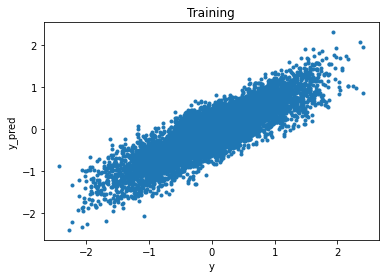

In [39]:
plt.plot(target_new.flatten(), output.detach().numpy().flatten(), '.')
plt.title('Training')
plt.xlabel('y')
plt.ylabel('y_pred')

Text(0, 0.5, 'y_pred')

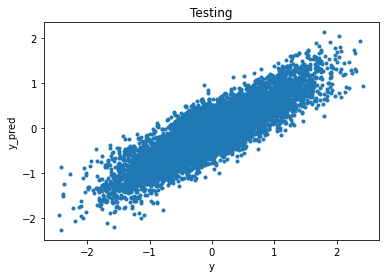

In [37]:
plt.plot(y_test.flatten(), test_out.detach().numpy().flatten(), '.')
plt.title('Testing')
plt.xlabel('y')
plt.ylabel('y_pred')

In [40]:
train_loss= criterion(output, target_new)
test_loss = criterion(y_test, test_out)
print(train_loss,test_loss)

tensor(0.1092, grad_fn=<MseLossBackward>) tensor(0.5586, grad_fn=<MseLossBackward>)


C:\Users\zwdzw\anaconda3\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1000, 14])) that is different to the input size (torch.Size([1000, 1, 14])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [ ]:
def plot_dt_exp_comparison(yexp, ypred):

    fig, axs = plt.subplots(nrows = 3, ncols = 3, figsize = [10,8], dpi = 100, sharex=True, sharey=True)
    for i in range(9):
        plt.sca(axs.flatten()[i])
        plt.plot(ypred[i], '.-', lw = 1, c = 'k', alpha = 0.5, label = 'digital twin prediction')
        plt.plot(yexp[i], '.-', lw = 1, c = 'b', alpha = 0.5, label = 'experimental outcome')
        plt.xlabel('# pendulum')
        plt.ylabel('output angle')
        plt.title(f'Initial conditions {i}')
        plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.savefig('img/coupled_pendula_dt_examples.png')
    plt.show()
    
plot_dt_exp_comparison(y_test_new,2*test_out.detach())

In [ ]:

class Net2(nn.Module):

    def __init__(self):
        super(Net2, self).__init__()

        self.layer1 = nn.Linear(14, 120)
        self.layer2 = nn.Linear(120, 120)
        self.layer3 = nn.Linear(120, 120)
        self.layer4 = nn.Linear(120, 84)
        self.layer5 = nn.Linear(84, 42)
        self.layer6 = nn.Linear(42, 7)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.layer1(x))
        x = x+F.relu(self.layer2(x))
        x = x+F.relu(self.layer3(x))
        x = F.relu(self.layer4(x))
        x = F.tanh(self.layer5(x))
        x = F.relu(self.layer6(x))
        return x


net2 = Net2()
print(net2)

params2 = list(net2.parameters())
print(len(params2))
print(params2[0].size())

In [ ]:
x_data=torch.tensor(x)
input = x_data
out = net2(input)
print(out)
print(out.shape)

In [ ]:
target=y1[0:1000,:,:]
target_new=target.view(1000,7)

In [ ]:
import torch.optim as optim
optimizer = torch.optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-06, weight_decay=0.1, amsgrad=False)  #adam optimizer
    
for i in range(200):
    optimizer.zero_grad()   # zero the gradient buffers
    output = net2(input)
    loss = criterion(output, target_new)
    loss.backward()
    optimizer.step()
    print(loss)
